# Import necessary module

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from num2words import num2words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Load dataset and do preprocessing

In [2]:
def convert_lower_case(data):
    return np.char.lower(data)

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-.,/:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, "'", "")
    return data

def remove_non_alpha(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        if w.isalpha() == True:
            new_text = new_text + " " + w
    return new_text

def remove_single_character(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        if len(w) > 1:
            new_text = new_text + " " + w
    return new_text

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

def remove_unused_words(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        if w not in ['www','com','edu']:
            new_text = new_text + " " + w
    return new_text

def stemming(data):
    stemmer= PorterStemmer()
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

folder = 'E:\\S2\\Sistem Intelijen\\Tugas\\UAS\\dataset\\'
df = pd.DataFrame({'file': [], 'preprocessed_text': [], 'tfidf': [], 'label': []})
for r, d, f in os.walk(folder):
    for file in f:
        if '.txt' in file:
            label = 0
            if file[:5] == 'spmsg':
                label = 1
            dft = pd.DataFrame([[file,'',[],label]], columns = ['file','preprocessed_text','tfidf','label'])
            df = df.append(dft)
df.reset_index(drop=True,inplace=True)

data = ''
for index,col in df.iterrows():
    with open(folder + col['file'], errors='ignore') as f:
        for i,line in enumerate(f):
            if i == 2:
                data = convert_lower_case(line)
                data = remove_punctuation(data)
                data = remove_non_alpha(data)
                data = remove_single_character(data)
                data = remove_unused_words(data)
                data = remove_stop_words(data)
                data = stemming(data)
                df.at[index, 'preprocessed_text'] = data

print('Dataframe:\n', df)

Dataframe:
               file                                  preprocessed_text tfidf  \
0      3-1msg1.txt   deat sun dec est michael mmors yorku ca subje...    []   
1      3-1msg2.txt   discuss np np remind ago read sourc forget cr...    []   
2      3-1msg3.txt           much restrict np np np pro quit restrict    []   
3    3-375msg1.txt   listserv intern confer second circular februa...    []   
4    3-378msg1.txt   anyon point book articl caus construct korean...    []   
..             ...                                                ...   ...   
957   spmsgc95.txt   congratul select enter vacat adventur florida...    []   
958   spmsgc96.txt   http capitalfm extravaganza keep date action ...    []   
959   spmsgc97.txt   spam receiv messag member safemail list wish ...    []   
960   spmsgc98.txt   spam receiv messag member safemail list wish ...    []   
961   spmsgc99.txt   dear internet user dear internet user sound f...    []   

     label  
0      0.0  
1      0.0  


# Create tf-idf score from the data

In [3]:
num_input = 20

txt = []
for index,col in df.iterrows():
    txt.append(col['preprocessed_text'])

tfidf = TfidfVectorizer(max_features=num_input)
vector = tfidf.fit_transform(txt)
vector_array = vector.toarray()

for index,col in df.iterrows():
    df.at[index, 'tfidf'] = vector_array[index]

print('Feature/input (', num_input, ' most common words from dataset ):\n', tfidf.get_feature_names())
print('\nDataframe:\n', df)

Feature/input ( 20  most common words from dataset ):
 ['address', 'email', 'free', 'http', 'inform', 'languag', 'linguist', 'list', 'mail', 'money', 'name', 'one', 'order', 'pleas', 'program', 'receiv', 'report', 'send', 'univers', 'work']

Dataframe:
               file                                  preprocessed_text  \
0      3-1msg1.txt   deat sun dec est michael mmors yorku ca subje...   
1      3-1msg2.txt   discuss np np remind ago read sourc forget cr...   
2      3-1msg3.txt           much restrict np np np pro quit restrict   
3    3-375msg1.txt   listserv intern confer second circular februa...   
4    3-378msg1.txt   anyon point book articl caus construct korean...   
..             ...                                                ...   
957   spmsgc95.txt   congratul select enter vacat adventur florida...   
958   spmsgc96.txt   http capitalfm extravaganza keep date action ...   
959   spmsgc97.txt   spam receiv messag member safemail list wish ...   
960   spmsgc98.t

# Split train and test data

In [4]:
ham = df.query('label == 0')
ham.reset_index(drop=True,inplace=True)
spam = df.query('label == 1')
spam.reset_index(drop=True,inplace=True)

num_train = int(len(ham)*0.8)

frames = [ham.iloc[:num_train],spam.iloc[:num_train]]
train = pd.concat(frames)
train.reset_index(drop=True,inplace=True)
x_train = []
y_train = []
for index,col in train.iterrows():
    x_train.append(col['tfidf'])
    y_train.append(col['label'])
x_train = np.array(x_train)
y_train = np.array(y_train)

frames = [ham.iloc[num_train:len(ham)],spam.iloc[num_train:len(ham)]]
test = pd.concat(frames)
test.reset_index(drop=True,inplace=True)
x_test = []
y_test = []
for index,col in test.iterrows():
    x_test.append(col['tfidf'])
    y_test.append(col['label'])
x_test = np.array(x_test)
y_test = np.array(y_test)

print('The number of total dataset : ' + str(len(df)))
print('  The number of spam : ' + str(len(spam)))
print('  The number of ham  : ' + str(len(ham)))
print('The number of train dataset : ' + str(len(train)))
print('  The number of spam : ' + str(train.query('label == 1').shape[0]))
print('  The number of ham  : ' + str(train.query('label == 0').shape[0]))
print('The number of test dataset : ' + str(len(test)))
print('  The number of spam : ' + str(test.query('label == 1').shape[0]))
print('  The number of ham  : ' + str(test.query('label == 0').shape[0]))

The number of total dataset : 962
  The number of spam : 481
  The number of ham  : 481
The number of train dataset : 768
  The number of spam : 384
  The number of ham  : 384
The number of test dataset : 194
  The number of spam : 97
  The number of ham  : 97


# Build deep learning model

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(num_input,)),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,569
Trainable params: 5,569
Non-trainable params: 0
_________________________________________________________________
None


# Train model

In [13]:
history = model.fit(x_train, y_train, epochs=30, batch_size=20).history

Train on 768 samples
Epoch 1/30
768/768 [==============================] - 1s 888us/sample - loss: 0.6038 - acc: 0.8112
Epoch 2/30
768/768 [==============================] - 0s 122us/sample - loss: 0.3488 - acc: 0.9128
Epoch 3/30
768/768 [==============================] - 0s 119us/sample - loss: 0.1983 - acc: 0.9388
Epoch 4/30
768/768 [==============================] - 0s 132us/sample - loss: 0.1641 - acc: 0.9427
Epoch 5/30
768/768 [==============================] - 0s 132us/sample - loss: 0.1489 - acc: 0.9440
Epoch 6/30
768/768 [==============================] - 0s 142us/sample - loss: 0.1409 - acc: 0.9466
Epoch 7/30
768/768 [==============================] - 0s 129us/sample - loss: 0.1350 - acc: 0.9505
Epoch 8/30
768/768 [==============================] - 0s 127us/sample - loss: 0.1306 - acc: 0.9466
Epoch 9/30
768/768 [==============================] - 0s 114us/sample - loss: 0.1242 - acc: 0.9531
Epoch 10/30
768/768 [==============================] - 0s 122us/sample - loss: 0.1206 - 

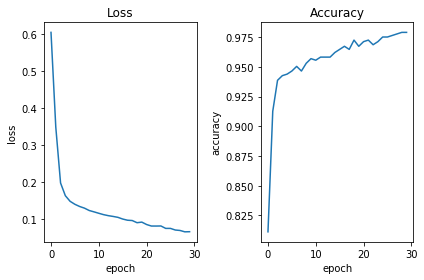

In [14]:
plt.subplot(1, 2, 1)
plt.plot(history['loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(history['acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

# Test data and result

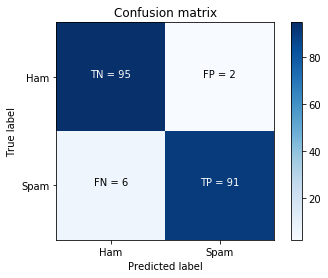

Accuracy  = 0.9587628865979382
Precision = 0.978494623655914
Recall    = 0.9381443298969072


In [15]:
predictions = model.predict_classes(x_test)
cm = confusion_matrix(y_test, predictions)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
classes = ['Ham','Spam']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
thresh = cm.max() / 2
s = [['TN','FP'], ['FN','TP']]
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(s[i][j]) + " = " + str(cm[i][j]), horizontalalignment = "center",
            color = "white" if cm[i,j] > thresh else "black")
plt.show()

acc = accuracy_score(y_test, predictions)
print('Accuracy  =', acc)
ps = precision_score(y_test, predictions)
print('Precision =', ps)
rs = recall_score(y_test, predictions)
print('Recall    =', rs)